# Classification+Shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Necessary Libraries

In [ ]:
!pip install matplotlib seaborn scikit-learn
!pip install shap xgboost
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import shap
import xgboost as xgb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.8 MB/s eta 0:00:00


# Part_1: Classification

In [ ]:


# Assuming your train and test CSV files are already uploaded to Google Colab
train_data = pd.read_csv('/content/drive/MyDrive/Thesis/Brain_Tumor_Dataset/SHAP_data/concatenated_data_Train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Thesis/Brain_Tumor_Dataset/SHAP_data/concatenated_data_Test.csv')

# Display information about the loaded data
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (677, 10)
Test data shape: (162, 10)


In [ ]:
# Assuming your train and test CSV files are already loaded into train_data and test_data DataFrames

# Step 1: Separate Features (X) and Label (y)
X_train = train_data.iloc[:, 1:-1]  # Exclude the first column (Sample) and the last column (Grade)
y_train = train_data['grade']  # Assuming 'Grade' is the column for labels

X_test = test_data.iloc[:, 1:-1]  # Exclude the first column (Sample) and the last column (Grade)
y_test = test_data['grade']  # Assuming 'Grade' is the column for labels

# Display shapes of X and y for train and test sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (677, 8), y_train shape: (677,)
X_test shape: (162, 8), y_test shape: (162,)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-merror:0.20532	validation_0-mlogloss:1.09007	validation_1-merror:0.20370	validation_1-mlogloss:1.09009
[1]	validation_0-merror:0.20532	validation_0-mlogloss:1.08166	validation_1-merror:0.20370	validation_1-mlogloss:1.08171
[2]	validation_0-merror:0.20532	validation_0-mlogloss:1.07339	validation_1-merror:0.20370	validation_1-mlogloss:1.07346
[3]	validation_0-merror:0.20532	validation_0-mlogloss:1.06525	validation_1-merror:0.20370	validation_1-mlogloss:1.06535
[4]	validation_0-merror:0.20532	validation_0-mlogloss:1.05725	validation_1-merror:0.20370	validation_1-mlogloss:1.05740
[5]	validation_0-merror:0.18021	validation_0-mlogloss:1.04922	validation_1-merror:0.18519	validation_1-mlogloss:1.04943
[6]	validation_0-merror:0.18021	validation_0-mlogloss:1.04146	validation_1-merror:0.18519	validation_1-mlogloss:1.04169
[7]	validation_0-merror:0.18021	validation_0-mlogloss:1.03368	validation_1-merror:0.18519	validation_1-mlogloss:1.03400
[8]	validation_0-merror:0.18021	validati

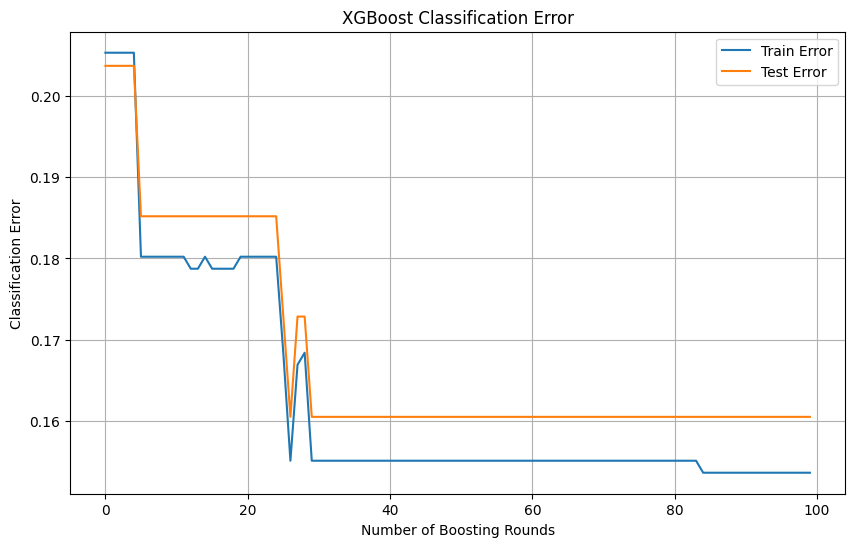

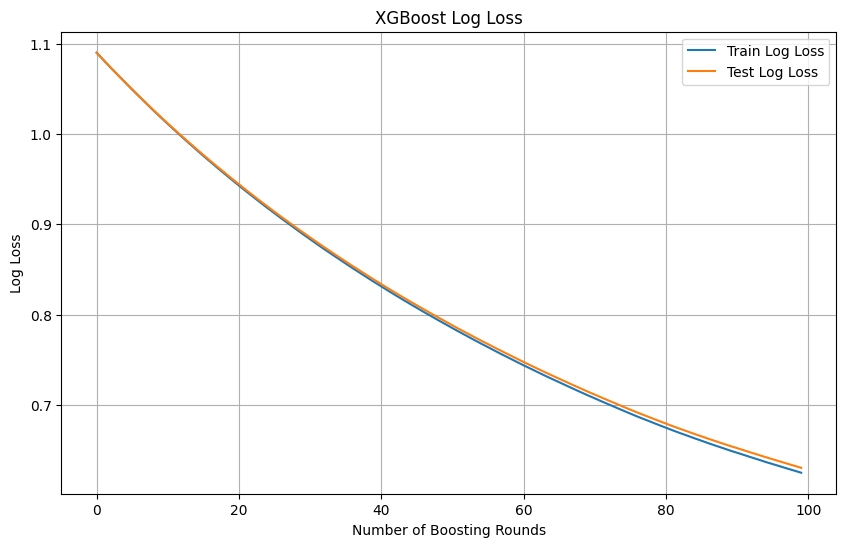

In [ ]:

# Assuming X_train, X_test, y_train, y_test are already defined

# Adjust labels to start from 0
y_train_adjusted = y_train - y_train.min()
y_test_adjusted = y_test - y_test.min()

# Convert categorical features to numeric if necessary
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category').cat.codes
        X_test[col] = X_test[col].astype('category').cat.codes

# Initialize XGBoost classifier with hyperparameters
model = XGBClassifier(objective='multi:sigmoid', num_class=3, learning_rate=0.01, max_depth=3, min_child_weight=1)

# Train the model with evaluation set and early stopping
eval_set = [(X_train, y_train_adjusted), (X_test, y_test_adjusted)]
model.fit(X_train, y_train_adjusted, eval_metric=["merror", "mlogloss"], eval_set=eval_set, early_stopping_rounds=10, verbose=True)

# Get evaluation results
results = model.evals_result()

# Plot validation curves for error and log loss
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# Plotting the validation error and log loss curves
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['merror'], label='Train Error')
plt.plot(x_axis, results['validation_1']['merror'], label='Test Error')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train Log Loss')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Test Log Loss')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.grid()
plt.legend()
plt.show()






Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        70
           1       0.80      0.62      0.70        39
           2       0.80      0.89      0.84        53

    accuracy                           0.84       162
   macro avg       0.83      0.81      0.81       162
weighted avg       0.84      0.84      0.83       162



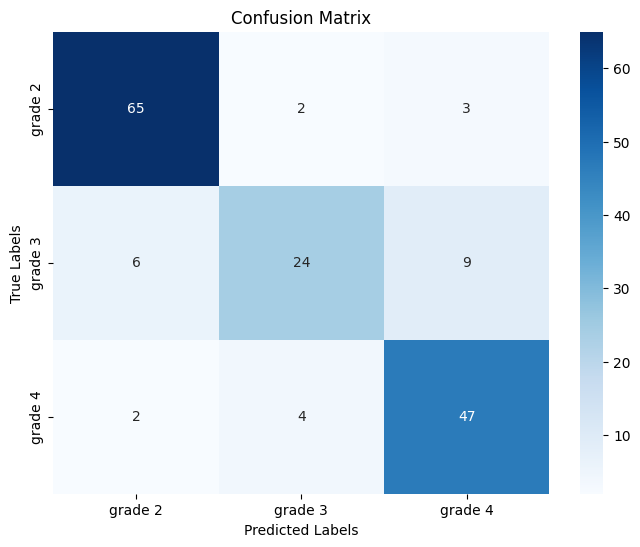

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_test_adjusted and predictions are already defined
predictions = model.predict(X_test)
# Print classification report
print("Classification Report:")
print(classification_report(y_test_adjusted, predictions))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_adjusted, predictions)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=['grade 2', 'grade 3', 'grade 4'],
            yticklabels=['grade 2', 'grade 3', 'grade 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
predictions = model.predict(X_test)
print("Predictions:", predictions)
print("True Labels:", y_test_adjusted)


Predictions: [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 2 2 2 2 2 2 2 2 2 1 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 2 1 2 1 2 2 0 2 2 2 2 0 2 1 2 2 2 0
 2 0 0 0 0 0 0 0 2 0 0 0 0 2 1 0 1 1 1 0 0 2 2 2 2 1 1 2 2 2 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 2 2 1 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
True Labels: 0      0
1      0
2      0
3      0
4      0
      ..
157    2
158    2
159    2
160    2
161    2
Name: grade, Length: 162, dtype: int64


# Part_2:SHAP_Analysis

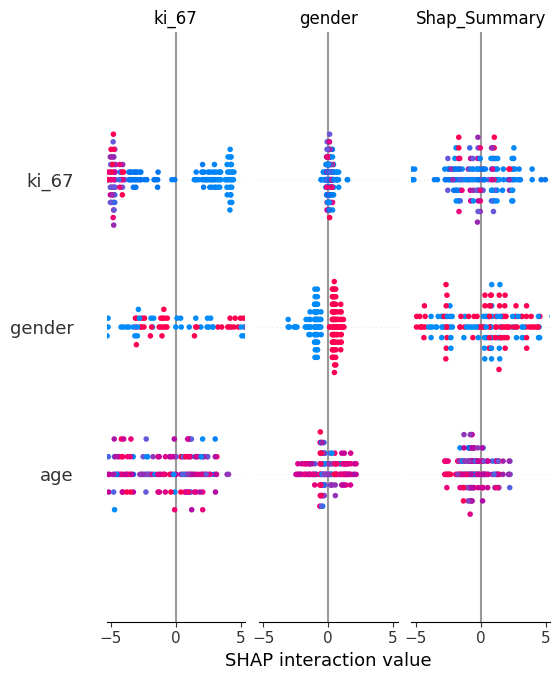

In [ ]:
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test are already defined and prepared

# Train a model (e.g., XGBoost) on your training data
model = xgb.XGBClassifier()
model.fit(X_train, y_train_adjusted)

# Initialize the SHAP explainer with the trained model
explainer = shap.TreeExplainer(model)

# Compute SHAP values on the test set
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test, max_display=None, plot_type='violin', show=False)
plt.title('Shap_Summary')
plt.show()

